In [1]:
import numpy as np
from exp_family import *
from projectors import *

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn

In [35]:
def sgd(objective, sample_dist, zero_point, projector, strong_convexity_coef = None, 
        C = 1, problem = "KL", acceleration = False, max_iter = 10**5):
    cur_theta = zero_point
    estim = []
    thetas = [cur_theta]
    dim = len(zero_point[0])
    if strong_convexity_coef != None:
        lam = strong_convexity_coef
    else:
        acceleration = False
        lam = 0
    for i in range(max_iter):
        f_theta = sample_dist(*cur_theta)
        cur_x = f_theta.sample()
        # estimation part
        x = cur_x
        tmp = objective(x)/f_theta.pdf(x)
        if i == 0:
            cur_estim = tmp
        else:
            #print(estim)
            cur_estim = tmp + estim[i - 1] * i
            cur_estim = cur_estim/(i + 1)
        estim.append(cur_estim)
        # gradient part
        if problem == "KL":
            grad = tuple((g_A - t)*tmp for g_A, t in zip(f_theta.grad_A(),f_theta.T(x)))
            coef = lam**2/2
        elif problem == "Var":
            grad = tuple((g_A - t)*(tmp**2) for g_A, t in zip(f_theta.grad_A(),f_theta.T(x)))
            coef = lam**(2 + dim/2)/(2*(2*np.pi)**(dim/2))
        else:
            raise ValueError('problem should be equal to either "KL" or "Var"')
        # step part
        if acceleration:
            if i == 0:
                print('here')
            step_size = C/(coef*(i+1))
        else:
            step_size = C/np.sqrt(i+1)
            #step_size = C
        cur_theta = tuple(theta_elem - step_size*g for theta_elem, g in zip(cur_theta, grad))
        cur_theta = projector(*cur_theta)
        thetas.append(cur_theta)
    return estim, thetas

In [36]:
obj = lambda x: x.dot(x) <= 4
l_min = 1e-2
l_max = 10
zero_point = (np.array([0,0,0]), np.eye(3))
projector = CoordProjector(BoxProjector(-1, 1), EigenBoxProjector(l_min, l_max))

### Estimations using KL-divergence without acceleration

In [42]:
estim0, thetas0 = sgd(obj, GaussianDistribution, zero_point, projector, max_iter = 5*10**5, C=1e-2)

In [43]:
thetas0[::10000]

[(array([0, 0, 0]), array([[ 1.,  0.,  0.],
         [ 0.,  1.,  0.],
         [ 0.,  0.,  1.]])),
 (array([-0.13578518, -0.01736642,  0.05552159]),
  array([[ 1.28430521,  0.02529529, -0.04813498],
         [ 0.02529529,  1.27867203,  0.02898869],
         [-0.04813498,  0.02898869,  1.15030355]])),
 (array([ 0.10655449,  0.01750819, -0.01544609]),
  array([[ 1.24254652,  0.00462538, -0.00916116],
         [ 0.00462538,  1.23746337,  0.08153263],
         [-0.00916116,  0.08153263,  1.25563852]])),
 (array([-0.04650129, -0.03906277, -0.0124837 ]),
  array([[ 1.28219089, -0.02239379,  0.02158876],
         [-0.02239379,  1.19888859,  0.02490682],
         [ 0.02158876,  0.02490682,  1.271603  ]])),
 (array([ 0.0393912 ,  0.02773377,  0.06020071]),
  array([[  1.21259171e+00,   1.45716799e-03,   2.11939814e-03],
         [  1.45716799e-03,   1.20968687e+00,   5.84593245e-04],
         [  2.11939814e-03,   5.84593245e-04,   1.31030944e+00]])),
 (array([ 0.01032068, -0.01602609,  0.059891

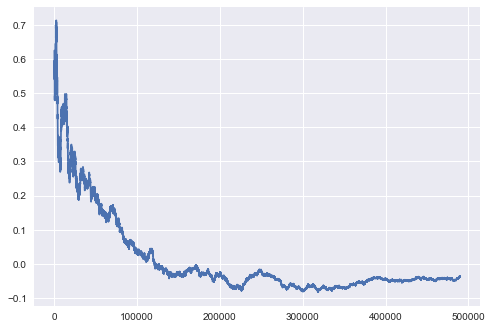

In [80]:
true_value = np.pi*4/3*8
plt.plot(np.array(estim0)[10**4:] - true_value)

### Estimations using KL-divergence with acceleration

In [95]:
estim1, thetas1 = sgd(obj, GaussianDistribution, zero_point, projector, max_iter=5*10**5, C=5e-3, strong_convexity_coef = 1/l_max, acceleration = True)

here


In [96]:
thetas1[::10000]

[(array([0, 0, 0]), array([[ 1.,  0.,  0.],
         [ 0.,  1.,  0.],
         [ 0.,  0.,  1.]])),
 (array([ 0.0352621 ,  0.03118624, -0.08296334]),
  array([[ 1.24074552, -0.04203989,  0.01439219],
         [-0.04203989,  1.27688629, -0.0507145 ],
         [ 0.01439219, -0.0507145 ,  1.18808969]])),
 (array([ 0.07078604, -0.07158319,  0.03197847]),
  array([[ 1.25194125,  0.00207198,  0.01891726],
         [ 0.00207198,  1.27474625, -0.02059605],
         [ 0.01891726, -0.02059605,  1.20525322]])),
 (array([ 0.03582646,  0.01956075, -0.04153024]),
  array([[ 1.26420125, -0.04862787,  0.01030965],
         [-0.04862787,  1.28026769,  0.01092203],
         [ 0.01030965,  0.01092203,  1.23089952]])),
 (array([-0.00383018, -0.01444315, -0.01599481]),
  array([[  1.32269064e+00,  -1.60607960e-02,   6.23956308e-04],
         [ -1.60607960e-02,   1.22943970e+00,   1.18135720e-02],
         [  6.23956308e-04,   1.18135720e-02,   1.22024001e+00]])),
 (array([ 0.02045606, -0.0180587 , -0.014360

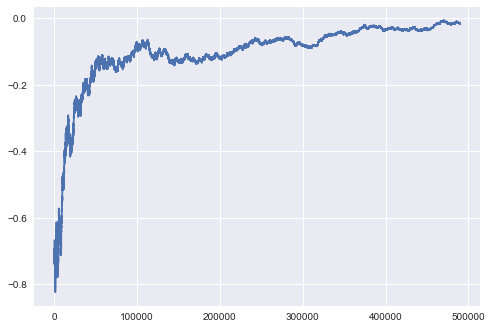

In [98]:
true_value = np.pi*4/3*8
plt.plot(np.array(estim1)[10**4:] - true_value)

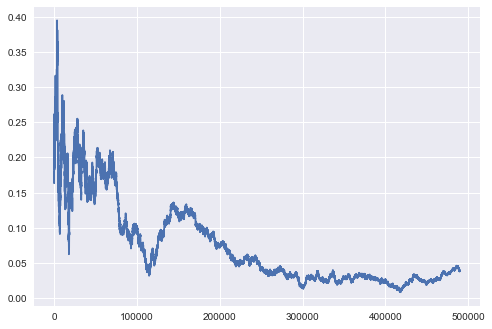

In [81]:
true_value = np.pi*4/3*8
plt.plot(np.array(estim1)[10**4:] - true_value)

In [79]:
estim1

[32.653569708469007,
 16.326784854234504,
 30.043103369185502,
 44.792360026235215,
 35.833888020988169,
 29.861573350823477,
 31.756876853479167,
 27.787267246794272,
 26.771505412025345,
 27.007524817862269,
 26.814759304603999,
 31.430177413908783,
 31.471801302148599,
 29.223815494852268,
 29.510170655841105,
 29.938184635613247,
 29.497502178055544,
 27.858752057052456,
 30.122664349964044,
 28.616531132465845,
 28.426188800128401,
 27.134089309213472,
 25.954346295769408,
 27.343861057061563,
 26.933793128806265,
 26.978456808914853,
 28.347308316516088,
 28.207282372087288,
 27.234617462704968,
 27.142458445460502,
 28.425918363626586,
 28.677885486048424,
 28.37520776739261,
 29.901356259074777,
 29.825768036479946,
 29.944625271724103,
 30.272793496916847,
 29.476141036471667,
 29.488134386765704,
 28.750931027096563,
 28.913861201592464,
 28.225435934887884,
 27.569030448030023,
 27.578193550355465,
 26.965344804792007,
 26.379141656861748,
 27.629451030253385,
 27.6758091588

### Estimations using variance without acceleration

In [59]:
estim2, thetas2 = sgd(obj, GaussianDistribution, zero_point, projector, max_iter=5*10**5, C=5e-2, problem='Var')

In [60]:
thetas2[::10000]

[(array([0, 0, 0]), array([[ 1.,  0.,  0.],
         [ 0.,  1.,  0.],
         [ 0.,  0.,  1.]])),
 (array([-1.,  1.,  1.]), array([[ 7.45873575,  2.06177022,  1.85074654],
         [ 2.06177022,  6.02276756, -3.37145017],
         [ 1.85074654, -3.37145017,  3.24145665]])),
 (array([-1.,  1.,  1.]), array([[ 7.45873575,  2.06177022,  1.85074654],
         [ 2.06177022,  6.02276756, -3.37145017],
         [ 1.85074654, -3.37145017,  3.24145665]])),
 (array([-1.,  1.,  1.]), array([[ 7.45873575,  2.06177022,  1.85074654],
         [ 2.06177022,  6.02276756, -3.37145017],
         [ 1.85074654, -3.37145017,  3.24145665]])),
 (array([-1.,  1.,  1.]), array([[ 7.45873575,  2.06177022,  1.85074654],
         [ 2.06177022,  6.02276756, -3.37145017],
         [ 1.85074654, -3.37145017,  3.24145665]])),
 (array([-1.,  1.,  1.]), array([[ 7.45873575,  2.06177022,  1.85074654],
         [ 2.06177022,  6.02276756, -3.37145017],
         [ 1.85074654, -3.37145017,  3.24145665]])),
 (array([-1.,  1

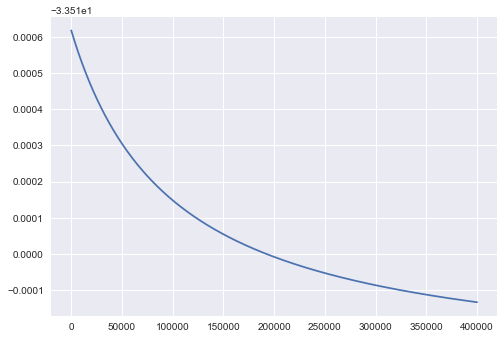

In [61]:
true_value = np.pi*4/3*8
plt.plot(np.array(estim2)[10**5:] - true_value)

### Estimations using variance with acceleration

In [62]:
estim3, thetas3 = sgd(obj, GaussianDistribution, zero_point, projector, 
                      max_iter=5*10**5, C=1e-1, problem='Var', strong_convexity_coef = 1/l_max, acceleration = True)

here


In [63]:
thetas3[::10000]

[(array([0, 0, 0]), array([[ 1.,  0.,  0.],
         [ 0.,  1.,  0.],
         [ 0.,  0.,  1.]])),
 (array([ 1., -1.,  1.]), array([[ 8.24786917,  3.33536782, -0.9253085 ],
         [ 3.33536782,  1.67749968,  1.34336206],
         [-0.9253085 ,  1.34336206,  9.42276895]])),
 (array([ 1., -1.,  1.]), array([[ 8.24786917,  3.33536782, -0.9253085 ],
         [ 3.33536782,  1.67749968,  1.34336206],
         [-0.9253085 ,  1.34336206,  9.42276895]])),
 (array([ 1., -1.,  1.]), array([[ 8.24786917,  3.33536782, -0.9253085 ],
         [ 3.33536782,  1.67749968,  1.34336206],
         [-0.9253085 ,  1.34336206,  9.42276895]])),
 (array([ 1., -1.,  1.]), array([[ 8.24786917,  3.33536782, -0.9253085 ],
         [ 3.33536782,  1.67749968,  1.34336206],
         [-0.9253085 ,  1.34336206,  9.42276895]])),
 (array([ 1., -1.,  1.]), array([[ 8.24786917,  3.33536782, -0.9253085 ],
         [ 3.33536782,  1.67749968,  1.34336206],
         [-0.9253085 ,  1.34336206,  9.42276895]])),
 (array([ 1., -1

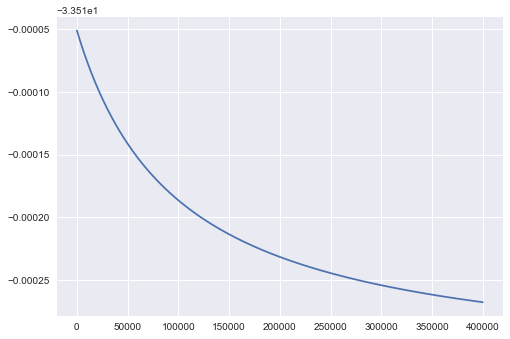

In [64]:
true_value = np.pi*4/3*8
plt.plot(np.array(estim3)[10**5:] - true_value)

ValueError: x and y must have same first dimension, but have shapes (900000,) and (400000,)

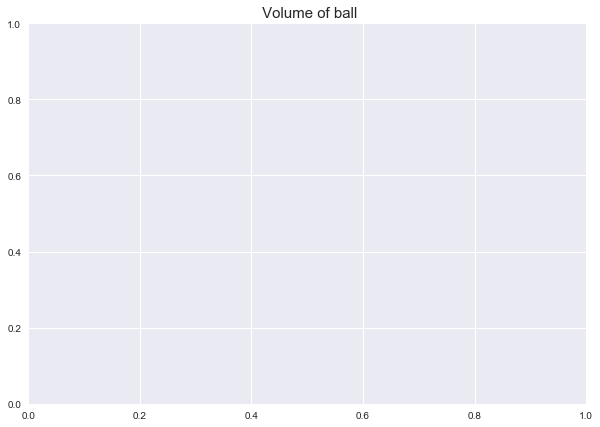

In [65]:
plt.figure(figsize=(10, 7))
plt.title(r" Volume of ball", # $\displaystyle x^TAx \le 4$
          fontsize=15)
plt.plot(np.arange(1e5, 1e6), np.fabs(np.array(estim0)[10**5:] - true_value), label = "KL without acceleration")
plt.plot(np.arange(1e5, 1e6), np.fabs(np.array(estim1)[10**5:] - true_value), label = "KL with acceleration")
plt.plot(np.arange(1e5, 1e6), np.fabs(np.array(estim2)[10**5:] - true_value), label = "Variance without acceleration")
plt.plot(np.arange(1e5, 1e6), np.fabs(np.array(estim3)[10**5:] - true_value), label = "Variance with acceleration")
plt.yscale('log')
plt.legend(loc = 'best')

plt.savefig('ball3d_sgd.png')

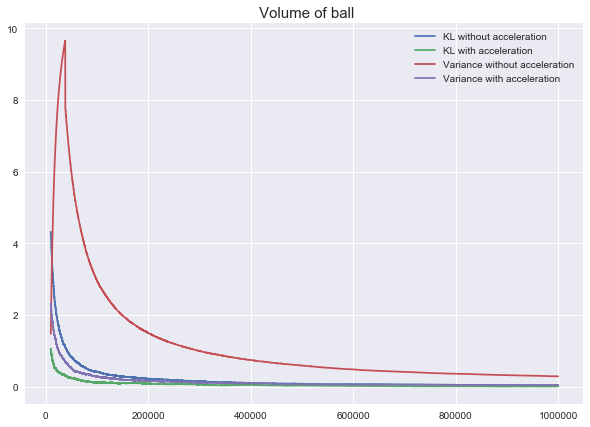

In [30]:
plt.figure(figsize=(10, 7))
plt.title(r" Volume of ball", # $\displaystyle x^TAx \le 4$
          fontsize=15)
plt.plot(np.arange(1e4, 1e6), np.fabs(np.array(estim0)[10**4:] - true_value), label = "KL without acceleration")
plt.plot(np.arange(1e4, 1e6), np.fabs(np.array(estim1)[10**4:] - true_value), label = "KL with acceleration")
plt.plot(np.arange(1e4, 1e6), np.fabs(np.array(estim2)[10**4:] - true_value), label = "Variance without acceleration")
plt.plot(np.arange(1e4, 1e6), np.fabs(np.array(estim3)[10**4:] - true_value), label = "Variance with acceleration")
#plt.yscale('log')
plt.legend(loc = 'best')

plt.savefig('ball_sgd1.png')

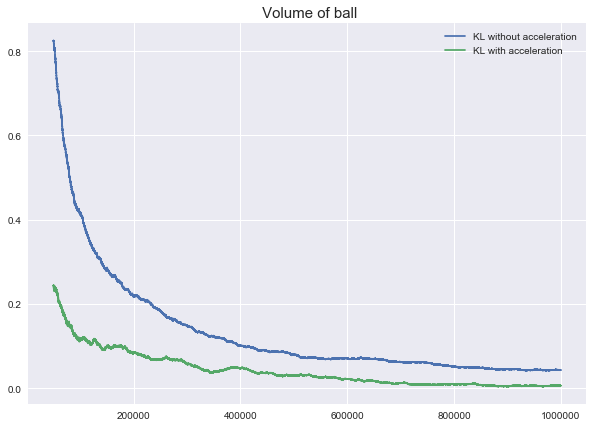

In [36]:
plt.figure(figsize=(10, 7))
plt.title(r" Volume of ball", # $\displaystyle x^TAx \le 4$
          fontsize=15)
plt.plot(np.arange(5e4, 1e6), np.fabs(np.array(estim0)[5*10**4:] - true_value), label = "KL without acceleration")
plt.plot(np.arange(5e4, 1e6), np.fabs(np.array(estim1)[5*10**4:] - true_value), label = "KL with acceleration")
#plt.plot(np.arange(1e4, 1e6), np.fabs(np.array(estim2)[10**4:] - true_value), label = "Variance without acceleration")
#plt.plot(np.arange(1e4, 1e6), np.fabs(np.array(estim3)[10**4:] - true_value), label = "Variance with acceleration")
#plt.yscale('log')
plt.legend(loc = 'best')

plt.savefig('ball_sgd2.png')

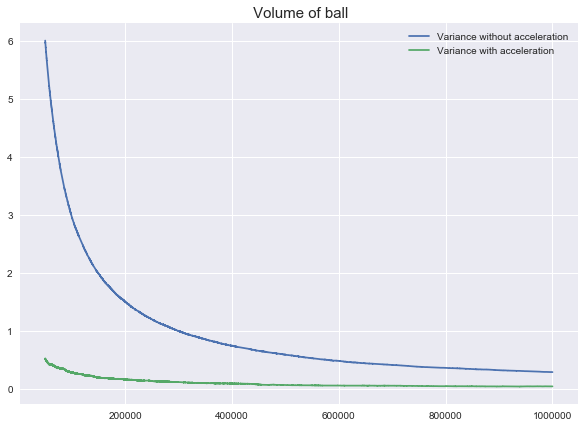

In [35]:
plt.figure(figsize=(10, 7))
plt.title(r" Volume of ball", # $\displaystyle x^TAx \le 4$
          fontsize=15)
#plt.plot(np.arange(5e4, 1e6), np.fabs(np.array(estim0)[5*10**4:] - true_value), label = "KL without acceleration")
#plt.plot(np.arange(5e4, 1e6), np.fabs(np.array(estim1)[5*10**4:] - true_value), label = "KL with acceleration")
plt.plot(np.arange(5e4, 1e6), np.fabs(np.array(estim2)[5*10**4:] - true_value), label = "Variance without acceleration")
plt.plot(np.arange(5e4, 1e6), np.fabs(np.array(estim3)[5*10**4:] - true_value), label = "Variance with acceleration")
#plt.yscale('log')
plt.legend(loc = 'best')

plt.savefig('ball_sgd3.png')